# Whale Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import dill as pickle

In [3]:
PATH = './data/whale/'
arch = resnet34
sz = 224
bs = 64

In [4]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
# train_df = pd.read_csv(label_csv)
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(label_csv, index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

In [6]:
# Define the MPA@5 metric
def mpa_at_k(probs, y, k):
    probs_sorted = np.argsort(-probs,axis=1)[:,:k] # Only interested in the top 5
    matches = np.array([a == b for a,b in zip(probs_sorted,y)])
    return np.sum(matches * np.array([[1.0/x for x in range(1,k+1)]])) / len(y)

def mpa_at_5(probs, y):
    return mpa_at_k(probs, y, 5)

def mpa_at_5_pyt(probs, y):
    probs = probs.cpu().numpy()
    return mpa_at_5(probs, y)

# Data Transform

In [7]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [8]:
data = get_data(sz,bs,val_idxs)

In [9]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [10]:
lrf = learn.lr_find()

 94%|█████████▍| 117/124 [00:57<00:03,  2.05it/s, loss=28.1]

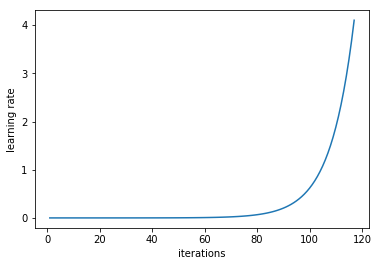

In [11]:
learn.sched.plot_lr()

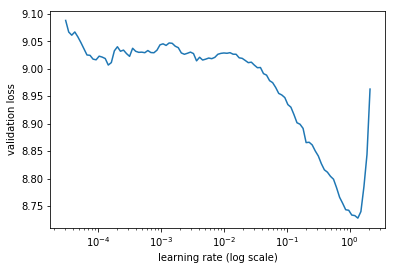

In [12]:
learn.sched.plot()

In [10]:
lr = 1e-1

In [11]:
lrs = np.array([lr/100,lr/10,lr])

# Improve Model

In [15]:
learn.fit(lr, 3, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      7.998363   7.636682   0.093706  
    1      7.212054   7.354345   0.11022                    
    2      6.604133   7.16026    0.119374                   


[array([7.16026]), 0.11937394247038917]

In [16]:
learn.precompute = False

In [17]:
learn.fit(lr, 3, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      5.762323   7.050555   0.138951  
    1      5.411929   7.001461   0.151379                   
    2      5.067695   6.981162   0.16566                    


[array([6.98116]), 0.16565989847715734]

In [18]:
learn.save('resnet34_224_lastlayer8')

In [19]:
learn.load('resnet34_224_lastlayer8')

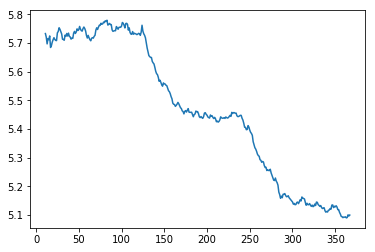

In [20]:
learn.sched.plot_loss()

In [21]:
learn.unfreeze()

In [22]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      5.694356   6.826598   0.157555  
    1      5.259015   6.65782    0.178156                   
    2      3.995053   6.482226   0.21698                    
    3      4.527859   6.767496   0.180558                   
    4      3.682441   6.570176   0.249704                   
    5      2.588312   6.522824   0.281531                   
    6      1.913484   6.52709    0.290017                   


[array([6.52709]), 0.29001692047377325]

In [23]:
learn.save('resnet34_224_all8')

In [24]:
learn.load('resnet34_224_all8')

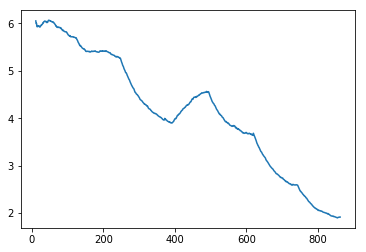

In [25]:
learn.sched.plot_loss()

# Increase Data Image Size

In [26]:
sz = 480

In [27]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [28]:
learn.freeze()

In [29]:
learn.fit(lr, 3, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      3.709984   6.891161   0.23066   
    1      3.298655   6.811185   0.248316                   
    2      2.884133   6.897547   0.249882                   


[array([6.89755]), 0.24988155668358714]

In [30]:
learn.save('resnet34_480_last_layer8')

In [31]:
learn.load('resnet34_480_last_layer8')

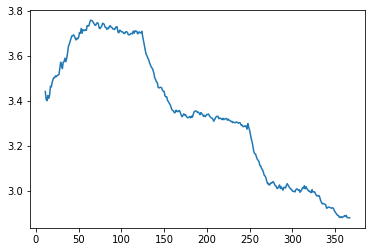

In [32]:
learn.sched.plot_loss()

In [13]:
learn.unfreeze()

In [34]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      2.611533   6.731252   0.281548  
    1      2.700984   6.886212   0.274932                   
    2      1.659785   6.718499   0.309086                   
    3      2.497006   7.542244   0.244298                   
    4      1.943807   6.999687   0.298951                   
    5      1.196555   6.94919    0.324154                   
    6      0.861634   7.00019    0.33544                     


[array([7.00019]), 0.335439932318105]

In [35]:
learn.save('resnet34_480_all8')

In [14]:
learn.load('resnet34_480_all8')

In [ ]:
learn.sched.plot_loss()

# Train with Everything

In [12]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [39]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.275285   12.299747  0.0       
    1      2.142824   11.515905  0.0                        
    2      1.559649   11.582547  0.0                        
    3      1.891396   12.303453  0.0                        
    4      1.417998   13.0239    0.0                        
    5      1.052204   13.103288  0.0                        
    6      0.832779   13.455582  0.0                         


[array([13.45558]), 0.0]

In [47]:
learn.save('resnet34_480_all8_no_val_cyclce_mult2')

In [16]:
learn.load('resnet34_480_all8_no_val_cyclce_mult2')

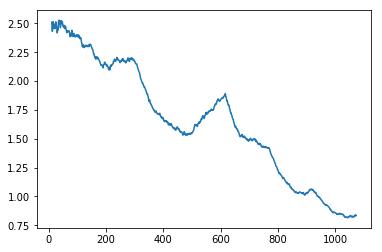

In [49]:
learn.sched.plot_loss()

In [17]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.718348   13.521296  0.0       
    1      1.79344    14.683218  0.0                        
    2      1.009143   15.178296  0.0                        
    3      1.676073   15.992226  0.0                        
    4      1.198963   15.317727  0.0                        
    5      0.708543   15.441183  0.0                         
    6      0.535545   15.181731  0.0                         
    7      1.282039   16.060207  0.0                        
    8      1.235372   15.874186  0.0                        
    9      0.970016   14.164837  0.0                         
    10     0.717407   14.976952  0.0                         
    11     0.516494   16.791317  0.0                         
    12     0.383293   15.81025   0.0                         
    13     0.319625   15.648257  0.0                         
    14     0.278652   15.130421  0.0                         



[array([15.13042]), 0.0]

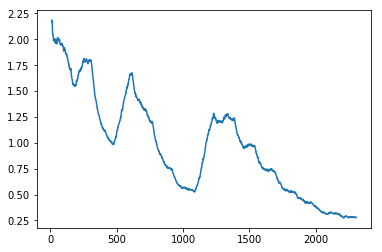

In [24]:
learn.sched.plot_loss()

# Create Submission

In [18]:
probs, _ = learn.TTA(is_test=True)

In [19]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [20]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [21]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [22]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission8.csv', index=False)

In [23]:
!kaggle competitions submit -c whale-categorization-playground -f submission8.csv -m "8th, transforms_side_on, 480px  training with 100% data, lr/100,lr/10,lr"

Successfully submitted to Humpback Whale Identification Challenge

Kaggle Score: 0.46999 (8 using transforms_side_on, training with 100% data, lr/100,lr/10,lr, image size 480)